# mecab colab에 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [4]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [6]:
#! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#ls
#cd /content/Mecab-ko-for-Google-Colab
#! bash install_mecab-ko_on_colab190912.sh

# imports

In [7]:
import konlpy
from konlpy.tag import Mecab

In [8]:
mecab = Mecab()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 뉴스기사 불러오기

In [18]:
# 기사 excel 파일 load
url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/article.xlsx'
news = pd.read_excel(url, header=1, usecols=['Code', 'Date', 'Journal', 'Title','Text','URL', 'Sentiment'])

In [80]:
# 중복 제거 (labeling에 '중복' 적힌것 있음)
news = news.drop_duplicates(['Date'], keep='first')

In [ ]:
# 기사 본문 기자의 이메일 OOOO @ asdfas.com 에서 @ 전 까지의 내용으로 저장
for i in range(len(news)):
    news.iloc[i]['Text'] = news.iloc[i]['Text'].split(sep='@')[0]

In [21]:
# 파일 덮어쓰고 다시 불러오기
news.to_excel("article.xlsx")
news = pd.read_excel('/content/article.xlsx', header=0, usecols=['Code', 'Date', 'Journal', 'Title','Text', 'Sentiment'])

# word2vec

In [ ]:
# https://devtimes.com/nb-text-classification-word2vec

In [22]:
news[:3]

,Code,Date,Journal,Title,Text,Sentiment
0,5930,2021.04.13 17:50,파이낸셜뉴스,"삼성전자 사내식당 2곳, 신세계·풀무원이 운영한다",삼성전자가 사내식당 2곳에 대해 실시한 외부 급식업체 경쟁입찰에서 '신세계푸드'와 ...,1
1,5930,2021.04.13 03:11,파이낸셜뉴스,"삼성전자 초청, 美 '반도체 회담'‥백악관 ""즉각적 결정 없을 것""",조 바이든 미국 대통령이 12일(현지시간) '반도체 공급망 강화 온라인 회담'에 참...,-1
2,5930,2021.04.08 14:55,파이낸셜뉴스,"[특징주]로보스타, 삼성-LG전자 미래 신성장 동력 ‘로봇산업’ 육성 ...",[파이낸셜뉴스]미래 신성장 동력인 로봇산업에 삼성전자와 LG전자가 힘을 쏟을 것이란...,1


In [25]:
tag_classes = ['NNP', 'NNG', 'VV+EC', 'XSV+EP']   # 추출할 품사 종류
stopwords = [np.nan, '삼성전자', '삼성', '인텔', '데일리', '기자', 'LG전자', 'LG', 'YG', 'JYP', '뉴스', '파이낸셜'] # 불용어 처리
Text = []
for main in news['Text']:    # 표에서 메인 기사 개수만큼 반복
    temp=[]                     # 임시저장할 배열
    for word in mecab.pos(main):        # 기사에서 (단어, 품사) 형태의 word 뽑아내서 하나씩 사용
        if word[1] in tag_classes:      # word[1]=>품사 가 추출할 품사종류에 들어 있으면
            if word[0] not in stopwords:    # 불용어에 들어있지 않으면
                temp.append(word[0])           # temp배열에 단어=> word[0] 추가
    Text.append(temp)         # test 셋 배열에 저장

In [26]:
len(Text)

1226

* num_fratures : 각 단어에 대한 임베딩된 벡터의 차원을 정한다.
* minwordcount : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않는다.
* num_workers : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않는다.
* context : word2vec을 수행하기 위한 컨텍스트 윈도우 크기를 지정한다.
* downsampling : word2vec 학습을 수행할 때 더 빠른 학습을 위해 정답 단어 라벨에 대한 다운샘플링 비율을 지정한다. (보통 0.001이 좋은 성능을 낸다고 한다)

In [27]:
# 학습 시 필요한 하이퍼 파라미터
num_features = 600    # 워드 백터 특정값 수
min_word_count = 2   # 단어에 대한 최소 빈도 수
num_workers = 4       # 프로세스 개수
context = 5         # 컨텍스트 윈도우 크기, 앞 뒤 5개씩 관련
downsampling = 1e-3   # 다운 샘플링 비율

In [28]:
# 진행 상황 나오는 log 설정
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
   level=logging.INFO)

In [29]:
from gensim.models import word2vec

2021-04-23 05:20:53,039 : INFO : 'pattern' package not found; tag filters are not available for English


In [30]:
model = word2vec.Word2Vec(Text,
                        workers=num_workers,
                        size=num_features,
                        min_count=min_word_count,
                        window=context,
                        sample=downsampling)

2021-04-23 05:20:53,062 : INFO : collecting all words and their counts
2021-04-23 05:20:53,070 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-23 05:20:53,133 : INFO : collected 11372 word types from a corpus of 250783 raw words and 1226 sentences
2021-04-23 05:20:53,135 : INFO : Loading a fresh vocabulary
2021-04-23 05:20:53,156 : INFO : effective_min_count=2 retains 7793 unique words (68% of original 11372, drops 3579)
2021-04-23 05:20:53,158 : INFO : effective_min_count=2 leaves 247204 word corpus (98% of original 250783, drops 3579)
2021-04-23 05:20:53,188 : INFO : deleting the raw counts dictionary of 11372 items
2021-04-23 05:20:53,190 : INFO : sample=0.001 downsamples 40 most-common words
2021-04-23 05:20:53,192 : INFO : downsampling leaves estimated 230342 word corpus (93.2% of prior 247204)
2021-04-23 05:20:53,217 : INFO : estimated required memory for 7793 words and 600 dimensions: 41302900 bytes
2021-04-23 05:20:53,218 : INFO : resetting la

In [57]:
# 모델의 하이퍼파라미터를 설정한 내용을 모델 이름에 담는다면 나중에 참고하기 용이하다.
# 모델을 저장하면 Word2Vec.load()를 통해 다시 사용할 수 있다.
model_name = "test_model"
model.save(model_name)

2021-04-23 05:24:54,362 : INFO : saving Word2Vec object under test_model, separately None
2021-04-23 05:24:54,366 : INFO : not storing attribute vectors_norm
2021-04-23 05:24:54,370 : INFO : not storing attribute cum_table
2021-04-23 05:24:54,774 : INFO : saved test_model


In [58]:
import numpy as np

* words : 단어의 모음인 하나의 리뷰가 들어간다.
* model : word2vec 모델을 넣는 공이며, 우리가 학습한 word2vec 모델이 들어간다.
* num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수를 뜻한다.

하나의 벡터를 만드는 과정을 빠르게 하기 위해 np.zeros를 사용해 미리 모두 0값을 가지는 벡터를 만든다. 그리고 문장의 단어가 모델 단어사전에 속하는지 보기 위해 model.wv.index2word를 set객체로 생성해서 index2word_set 변수에 할당한다. 다음 반복문을 통해 리뷰를 구성하는 단어에 대해 임베딩된 벡터가 있는 단어 벡터의 합을 구하고 사용한 단어의 전체 개수로 나누어 평균 벡터의 값을 구한다.


In [59]:
def get_features(words, model, num_features):
    # 출력 벡터 초기화
    feature_vector = np.zeros((num_features), dtype=np.float32)
    
    num_words = 0
    # 어휘 사전 준비
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        if w in index2word_set:
            num_words = 1
            # 사전에 해당하는 단어에 대해 단어 벡터를 더함
            feature_vector = np.add(feature_vector, model[w])
            
    # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
    feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

* news : 학습 데이터인 전체 리뷰 데이터를 입력
* model : word2vec 모델을 입력
* num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수

In [62]:
def get_dataset(news, model, num_features):
    dataset = list()
    
    for s in news:
        dataset.append(get_features(s, model, num_features))
        
    NewsFeatureVecs = np.stack(dataset)
    return NewsFeatureVecs

In [61]:
test_data_vecs = get_dataset(Text, model, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [63]:
len(test_data_vecs)

1226

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X = test_data_vecs
y = np.array(news['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1200)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
log_reg.score(X_train, y_train)

0.6061224489795919

In [69]:
log_reg.score(X_test, y_test)

0.6300813008130082

In [70]:
import matplotlib.pyplot as plt

In [44]:
x = range(100, 2000, 100)
test_score = []
train_score = []
for i in x:
    log_reg = LogisticRegression(class_weight='balanced', max_iter=i)
    log_reg.fit(X_train, y_train)
    train_score.append(log_reg.score(X_train, y_train))
    test_score.append(log_reg.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


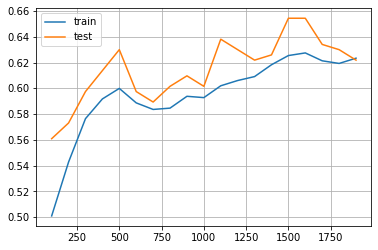

In [45]:
plt.plot(x, train_score, label='train')
plt.plot(x, test_score, label='test')
plt.grid()
plt.legend()
plt.show()

In [46]:
## 라벨링 안되어 있는거 하는 순서
# test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)
# test_news = list(test_data['Text'])
# test_sentences = []
# for review in test_review:
#     test_sentences.append(news.split())
#test_data_vecs = get_dataset(test_sentences, model, num_features)
#test_predicted = lgs.predict(test_data_vecs)


# TF-IDF

In [47]:
# https://devtimes.com/nb-text-classification-tf-idf

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF : TF(Term Frequency, 단어의 빈도), IDF(역문서 빈도, Inverse Document Frequency) 쉽게 말하자면 문장에서 단어의 빈도수를 계산하되 너무 자주 등장하는 단어는 크게 의미를 두지 않도록 가중치를 낮게 주자는 의미.



* min_df : 설정한 값보다 특정 토큰의 df값이 더 적게 나오면 벡터화 과정에서 제거
* analyzer : 분석하기 위한 기준 단위(word:단어 하나를 단위로, char:문자 하나를 단위로)
* sublinear_tf : 문서의 단어 빈도 수에 대한 스무딩(smoothing) 여부
* ngram_range : 빈도의 기본 단위를 설정할 n-gram 범위
* max_features : 각 벡터의 최대 길이


In [72]:
vectorizer = TfidfVectorizer(
            min_df=0.0,
            analyzer="word",
            sublinear_tf=True,
            ngram_range=(1,3),
            max_features=5000
        )

In [73]:
X = vectorizer.fit_transform(list(news['Text']))

In [74]:
y = np.array(news['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)
lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
lgs.score(X_train, y_train)

0.923469387755102

In [76]:
lgs.score(X_test, y_test)

0.7560975609756098

In [77]:
predict = lgs.predict(X_test)

In [78]:
predict[:50]

array([ 1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1, -1,  1,  1, -1,  1,  0,  1,  1])

In [79]:
y_test[:50]

array([ 1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1, -1,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0, -1,  1,  1,  1,  0, -1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  0,  1,  0])